Read the experiment results/logs

In [1]:
import numpy as np
import pandas as pd

from pathlib import Path
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib
matplotlib.use('Agg')       # Use non-interactive backend for matplotlib to save memory

from utils import print_log

Experiment folder

In [2]:
expt_datetime = datetime(2025, 7, 19, 3, 30, 35)
result_phrase = "train"  # or "test" or "validate"

expt_folder = Path("experiments") / expt_datetime.strftime("%Y%m%d_%H%M%S") / ("logs_" + result_phrase)

if not expt_folder.exists():
    print_log(f"Experiment folder {expt_folder} does not exist. Please check the path.", "error")

Before hand, we read the env config json and display information

In [3]:
env_config_path = expt_folder / "env_config.json"
if not env_config_path.exists():
    print_log(f"Environment config file {env_config_path} does not exist. Please check the path.", "error")

# Load environment configuration
with open(env_config_path, 'r') as f:
    env_config = json.load(f)

# Display environment configuration
print_log("Environment Configuration:")
for key, value in env_config.items():
    print_log(f"{key}: {value}")

[2025-07-22 03:07:40:857] Environment Configuration:
[2025-07-22 03:07:40:857] battery: {'capacity': 8.0, 'max_charging_rate': 4.0, 'max_discharging_rate': 4.0, 'efficiency': 1.0, 'initial_soc': 1.0}
[2025-07-22 03:07:40:857] reward_lambda: 0.5
[2025-07-22 03:07:40:857] h_network_type: HNetworkType.H_NETWORK2
[2025-07-22 03:07:40:857] init_soc: 0.15


In [4]:
max_battery_capacity = env_config.get("battery").get("capacity", 8)
max_battery_capacity

8.0

First, we read the progress.json of the selected phrase

In [5]:
from stable_baselines3.common.logger import read_json

# Read the logged .json file and open it as a Dataframe
log_file_path = expt_folder / "progress.json"
if log_file_path.exists():
    log_data = read_json(log_file_path)

log_data

2025-07-22 03:07:41.834670: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-22 03:07:41.842558: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753150061.851576  226755 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753150061.854111  226755 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753150061.860957  226755 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

time/iterations  rollout/ep_rew_mean  rollout/ep_len_mean  time/fps  \
0                  1            49.686275               1439.0       203   
1                  2            55.358705               1439.0       179   
2                  3            55.957002               1439.0       185   
3                  4            71.517069               1439.0       178   
4                  5            68.287061               1439.0       178   
..               ...                  ...                  ...       ...   
699              700          -655.096135               1439.0       161   
700              701          -656.108790               1439.0       161   
701              702          -656.330152               1439.0       161   
702              703          -654.282698               1439.0       161   
703              704          -653.818537               1439.0       161   

     time/time_elapsed  time/total_timesteps  train/learning_rate  \
0                   10                  2048                  NaN   
1                   22                  4096               0.0003   
2                   33                  6144               0.0003   
3                   45                  8192               0.0003   
4                   57                 10240               0.0003   
..                 ...                   ...                  ...   
699               8898               1433600               0.0003   
700               8911               1435648               0.0003   
701               8923               1437696               0.0003   
702               8935               1439744               0.0003   
703               8948               1441792               0.0003   

     train/entropy_loss  train/policy_gradient_loss  train/value_loss  \
0                   NaN                         NaN               NaN   
1             -1.416061                   -0.001564          0.164767   
2             -1.407861                   -0.002596          0.133416   
3             -1.402828                   -0.001475          0.281789   
4             -1.386314                   -0.000803          0.362616   
..                  ...                         ...               ...   
699            0.610830                    0.000612        108.223869   
700            0.622434                   -0.001835         43.853696   
701            0.631133                    0.001122         94.702951   
702            0.637992                    0.003232         72.538567   
703            0.650455                   -0.000198         25.749459   

     train/approx_kl  train/clip_fraction  train/loss  \
0                NaN                  NaN         NaN   
1           0.002665             0.013379    0.079471   
2           0.003135             0.025439    0.044045   
3           0.001864             0.008496    0.087627   
4           0.001174             0.001855    0.166733   
..               ...                  ...         ...   
699         0.004506             0.056006   57.580780   
700         0.012181             0.066553   12.470171   
701         0.009395             0.073682   27.566307   
702         0.012469             0.051807   22.411682   
703         0.009967             0.093848    3.978671   

     train/explained_variance  train/std  train/n_updates  train/clip_range  
0                         NaN        NaN              NaN               NaN  
1                   -0.047785   0.992547             10.0               0.2  
2                    0.102741   0.985936             20.0               0.2  
3                    0.488703   0.978292             30.0               0.2  
4                    0.565483   0.958055             40.0               0.2  
..                        ...        ...              ...               ...  
699                  0.830903   0.131012           6990.0               0.2  
700                  0.705133   0.128878           7000.0               0.2  

We then read the `h_network_<result_phrase>_loss_list.json`, and load it to a dataframe as well

`h_network_<result_phrase>_loss_list.json` is a json list

In [6]:
import json

h_network_loss_list_path = expt_folder / f"h_network_{result_phrase}_loss_list.json"
if h_network_loss_list_path.exists():
    with open(h_network_loss_list_path, "r") as f:
        h_network_loss_list = json.load(f)

    # Convert the list to a DataFrame
    h_network_loss_df = pd.DataFrame(h_network_loss_list)

In [7]:
h_network_loss_df

mean_loss  std_loss  num_batches
0     0.526298  0.061240            2
1     0.529979  0.022001            2
2     0.480346  0.013059            2
3     0.385339  0.042875            2
4     0.339727  0.041836            2
..         ...       ...          ...
196  -1.548855  0.012871            2
197  -1.551838  0.067442            2
198  -1.603599  0.048013            2
199  -1.727575  0.018098            2
200  -1.860300  0.017269            2

[201 rows x 3 columns]

We also read the reward of each episode from the agent interacting with the env

In [8]:
episodes_rewards_path = expt_folder / f"episodes_rewards.json"
if episodes_rewards_path.exists():
    with open(episodes_rewards_path, "r") as f:
        episodes_rewards = json.load(f)

    # Convert the list to a DataFrame
    episodes_rewards_df = pd.DataFrame(episodes_rewards)

episodes_rewards_df

sum      mean       std
0       49.686275  0.034528  0.032440
1       61.031134  0.042412  0.041941
2       58.610308  0.040730  0.039353
3       54.500290  0.037874  0.044109
4      133.757337  0.092952  0.070679
...           ...       ...       ...
1004 -1501.881214 -1.043698  1.342604
1005  -454.899031 -0.316122  0.984537
1006  -192.422457 -0.133720  0.653402
1007  -667.661788 -0.463976  0.813389
1008    22.482948  0.015624  0.282831

[1009 rows x 3 columns]

We also load the information of each episode into a list of dataframes

In [9]:
episode_info_folder = expt_folder / "episode_info"
if episode_info_folder.exists():
    episode_info_files = sorted(list(episode_info_folder.glob("*.json")))
    episode_info_dfs = []

    for file in episode_info_files:
        with open(file, "r") as f:
            episode_info = json.load(f)
            df = pd.DataFrame(episode_info)
            # add a column for the episode number
            df['episode'] = int(file.stem.split('_')[1])  # Assuming the file name is like "episode_0_info.json", "episode_1_info.json", etc.
            # convert the datetime strings to datetime objects using python isoformat
            df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601')

            # temporary fix
            # rename the battery_soc (kWh) column to battery_soc (%)
            # df.rename(columns={"battery_soc (kWh)": "battery_soc (%)"}, inplace=True)
            # compute the battery_soc (kWh) column
            # df['battery_soc (kWh)'] = df['battery_soc (%)'] * max_battery_capacity  # Assuming the battery capacity is 8 kWh


            episode_info_dfs.append(df)

            print_log(f"Loaded episode info from {file.name}")

    # Concatenate all DataFrames into one
    episode_info_df = pd.concat(episode_info_dfs, ignore_index=True)
    

[2025-07-22 03:07:42:776] Loaded episode info from episode_0001_info.json
[2025-07-22 03:07:42:783] Loaded episode info from episode_0002_info.json
[2025-07-22 03:07:42:790] Loaded episode info from episode_0003_info.json
[2025-07-22 03:07:42:796] Loaded episode info from episode_0004_info.json
[2025-07-22 03:07:42:802] Loaded episode info from episode_0005_info.json
[2025-07-22 03:07:42:808] Loaded episode info from episode_0006_info.json
[2025-07-22 03:07:42:815] Loaded episode info from episode_0007_info.json
[2025-07-22 03:07:42:820] Loaded episode info from episode_0008_info.json
[2025-07-22 03:07:42:826] Loaded episode info from episode_0009_info.json
[2025-07-22 03:07:42:832] Loaded episode info from episode_0010_info.json
[2025-07-22 03:07:42:838] Loaded episode info from episode_0011_info.json
[2025-07-22 03:07:42:844] Loaded episode info from episode_0012_info.json
[2025-07-22 03:07:42:850] Loaded episode info from episode_0013_info.json
[2025-07-22 03:07:42:855] Loaded episo

In [10]:
episode_info_df.head(20)

episode_index  current_step            datetime  battery_soc (kWh)  \
0              96             0 2013-08-28 00:00:02           0.150000   
1              96             1 2013-08-28 00:01:02           0.158333   
2              96             2 2013-08-28 00:02:02           0.157705   
3              96             3 2013-08-28 00:03:02           0.166038   
4              96             4 2013-08-28 00:04:02           0.165397   
5              96             5 2013-08-28 00:05:02           0.164771   
6              96             6 2013-08-28 00:06:02           0.173104   
7              96             7 2013-08-28 00:07:02           0.173959   
8              96             8 2013-08-28 00:08:02           0.174414   
9              96             9 2013-08-28 00:09:02           0.179618   
10             96            10 2013-08-28 00:10:02           0.181808   
11             96            11 2013-08-28 00:11:02           0.181188   
12             96            12 2013-08-28 00:12:02           0.182568   
13             96            13 2013-08-28 00:13:02           0.184372   
14             96            14 2013-08-28 00:14:02           0.192705   
15             96            15 2013-08-28 00:15:02           0.192104   
16             96            16 2013-08-28 00:16:02           0.191496   
17             96            17 2013-08-28 00:17:02           0.190886   
18             96            18 2013-08-28 00:18:02           0.190400   
19             96            19 2013-08-28 00:19:02           0.191366   

    user_load (W)  grid_load (W)  action (kW)  battery_action (kW)    reward  \
0             NaN            NaN          NaN                  NaN       NaN   
1      301.620664   4.304000e+03     4.000000             4.000000 -0.008872   
2      302.718374   5.684342e-14    -0.575982            -0.301621 -0.006089   
3      307.954288   4.302718e+03     4.000000             4.000000 -0.009795   
4      300.548825   0.000000e+00    -1.743370            -0.307954 -0.005178   
5      301.786413   0.000000e+00    -1.416105            -0.300549 -0.005367   
6      295.105055   4.301786e+03     4.000000             4.000000 -0.005739   
7      298.141884   7.055236e+02     0.410419             0.410419 -0.003630   
8      298.852069   5.164931e+02     0.218351             0.218351 -0.004247   
9      295.157742   2.796720e+03     2.497868             2.497868 -0.004605   
10     297.768258   1.346479e+03     1.051321             1.051321 -0.004489   
11     294.148045   5.684342e-14    -3.096828            -0.297768 -0.004038   
12     292.087376   9.567934e+02     0.662645             0.662645 -0.003002   
13     289.524251   1.157875e+03     0.865788             0.865788 -0.002313   
14     288.392771   4.289524e+03     4.000000             4.000000 -0.004096   
15     292.155333   0.000000e+00    -1.398934            -0.288393 -0.002951   
16     292.712060   0.000000e+00    -4.000000            -0.292155 -0.003093   
17     233.288495   0.000000e+00    -4.000000            -0.292712  0.021948   
18     223.187484   0.000000e+00    -4.000000            -0.233288  0.027871   
19     223.126766   6.868853e+02     0.463698             0.463698  0.028465   

    f_signal  g_signal  f_signal-predicted_mean  f_signal-predicted_log_var  \
0        NaN       NaN                      NaN                         NaN   
1   0.011011  0.006733                 0.099367                   -0.045184   
2   0.011670  0.000508                 0.100953                   -0.045969   
3   0.012857  0.006733                 0.108371                   -0.045824   
4   0.009839  0.000518                 0.104953                   -0.045730   
5   0.010229  0.000506                 0.109992                   -0.046980   
6   0.004746  0.006733                 0.113459                   -0.044477   
7   0.006569  0.000691                 0.107824                   -0.042636   
8   0.008127  0.000368                 0.109424          

In [11]:
episode_info_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1442586 entries, 0 to 1442585
Data columns (total 16 columns):
 #   Column                      Non-Null Count    Dtype         
---  ------                      --------------    -----         
 0   episode_index               1442586 non-null  int64         
 1   current_step                1442586 non-null  int64         
 2   datetime                    1442586 non-null  datetime64[ns]
 3   battery_soc (kWh)           1442586 non-null  float64       
 4   user_load (W)               1441577 non-null  float64       
 5   grid_load (W)               1441577 non-null  float64       
 6   action (kW)                 1441577 non-null  float64       
 7   battery_action (kW)         1441577 non-null  float64       
 8   reward                      1441577 non-null  float64       
 9   f_signal                    1441577 non-null  float64       
 10  g_signal                    1441577 non-null  float64       
 11  f_signal-predicted_mean 

---

Lets plot a graph with three subplot, with the first is the sum of rewards across each episodes, and the second is the mean, and the third is the s.d. of the per-step reward

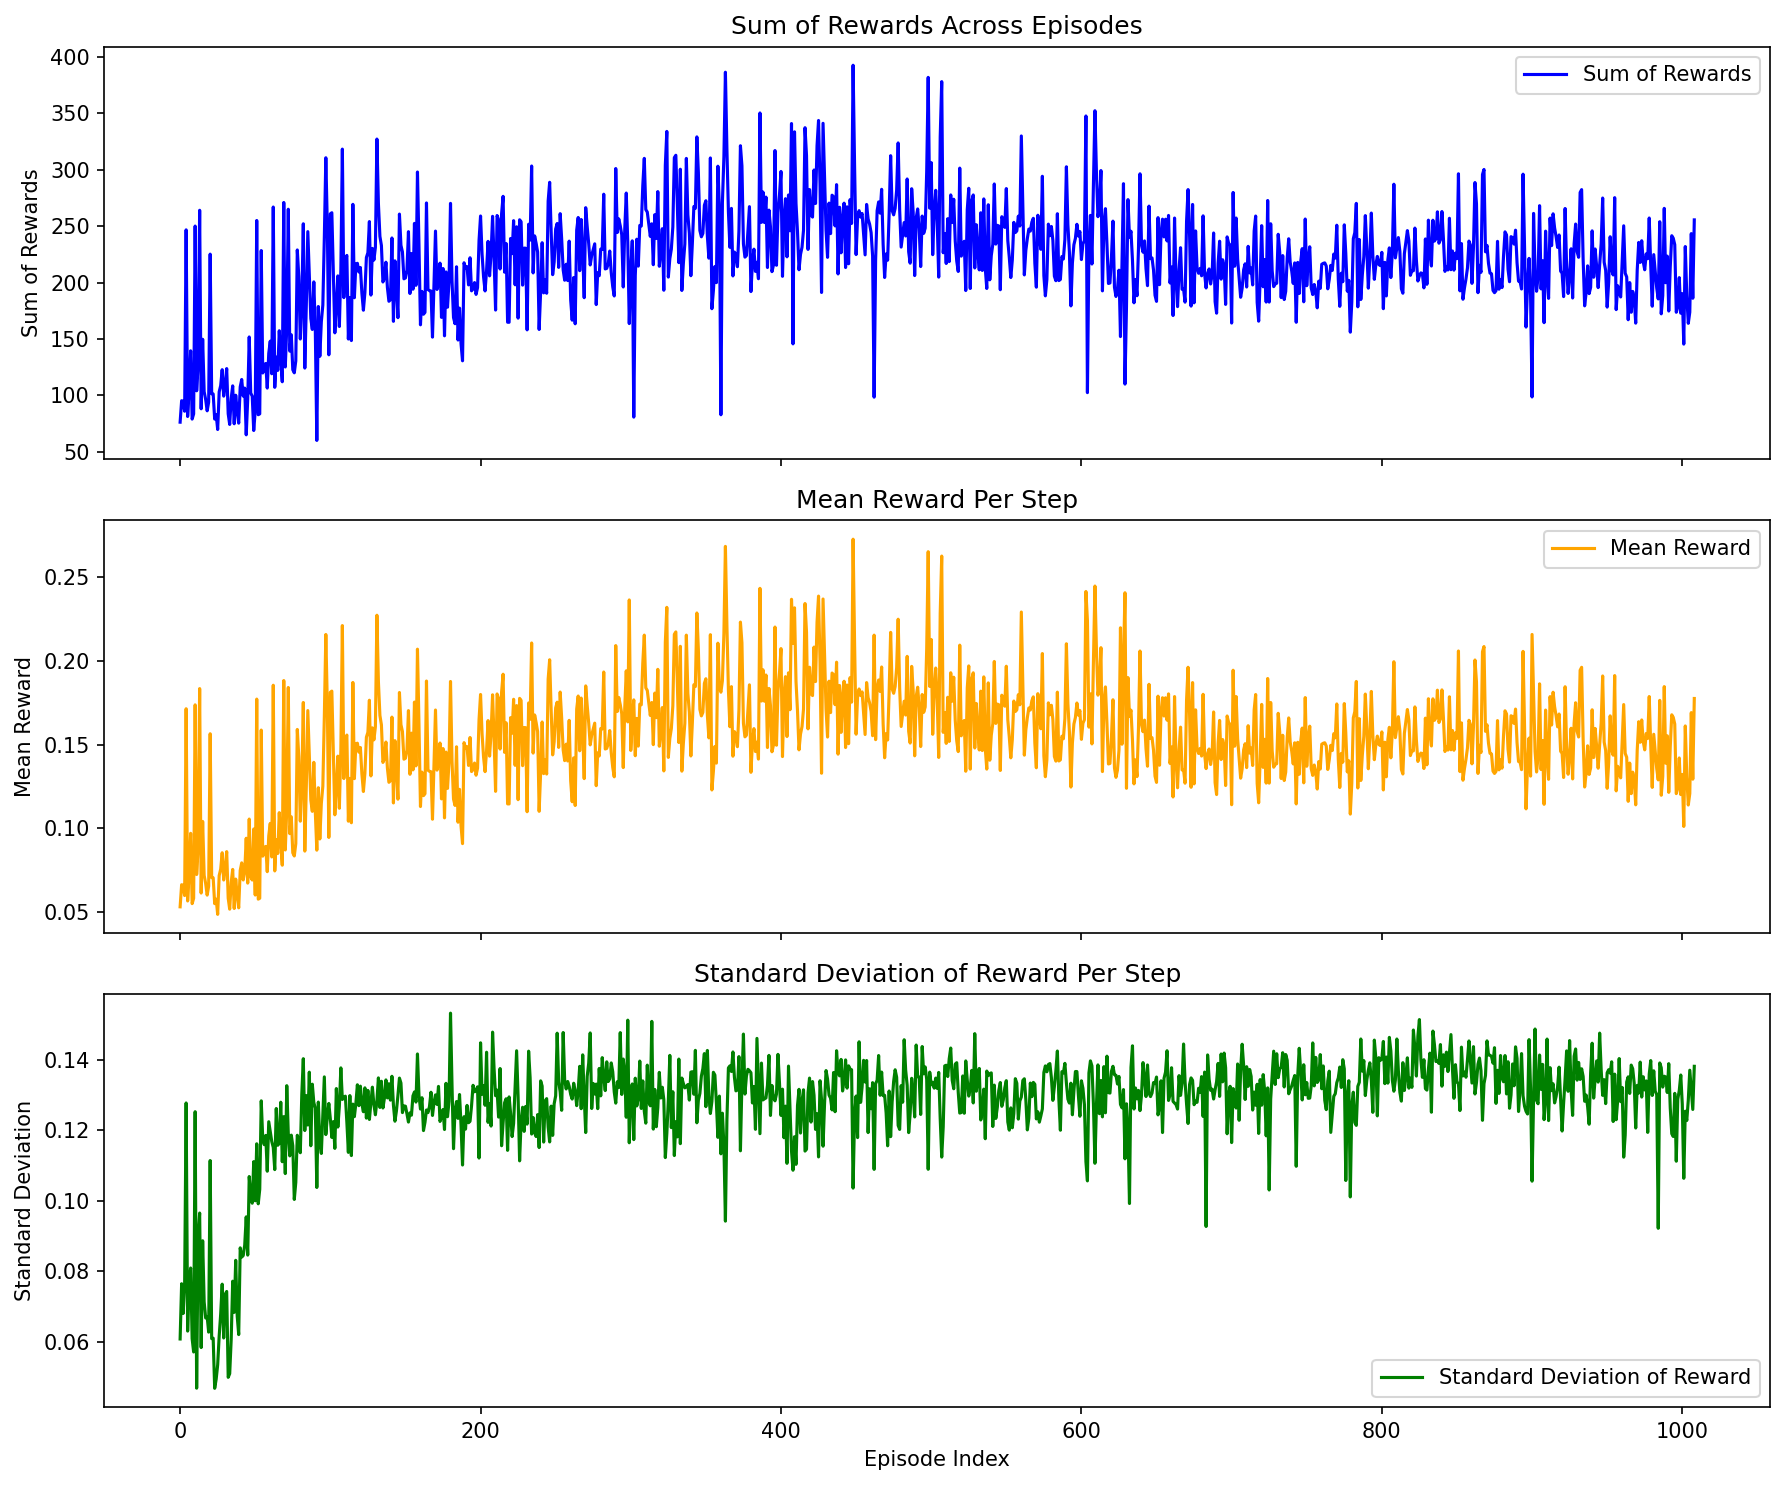

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

df_1 = episodes_rewards_df.reset_index()
df_1.rename(columns={"index": "episode_index"}, inplace=True)

# Plotting the results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True, dpi=150)
# Plot the sum of rewards across episodes
sns.lineplot(data=df_1, x="episode_index", y="sum", ax=ax1, label="Sum of Rewards", color="blue")
ax1.set_title("Sum of Rewards Across Episodes")
ax1.set_ylabel("Sum of Rewards")
ax1.legend()

# Plot the mean and std of per-step reward
# with the sd provided from df_1['std']
sns.lineplot(data=df_1, x="episode_index", y="mean", ax=ax2, label="Mean Reward", color="orange")
ax2.set_title("Mean Reward Per Step")
ax2.set_ylabel("Mean Reward")
ax2.legend()

# Plot the standard deviation of per-step reward
sns.lineplot(data=df_1, x="episode_index", y="std", ax=ax3, label="Standard Deviation of Reward", color="green")
ax3.set_title("Standard Deviation of Reward Per Step")
ax3.set_ylabel("Standard Deviation")
ax3.legend()

plt.xlabel("Episode Index")
plt.tight_layout()
plt.show()

# Save the figure
episodes_rewards_path = expt_folder / "graphs" / "episodes_rewards.png"
if not episodes_rewards_path.parent.exists():
    episodes_rewards_path.parent.mkdir(parents=True)
fig.savefig(episodes_rewards_path, dpi=300, bbox_inches='tight')

---

In [12]:
# we plot how the sum of f-signal and sum of g-signal changes over episodes
# we create three subplots, one for sum of rewards across episodes, one for sum of f-signal across episodes, and one for sum of g-signal across episodes

# Create a temporary dataframe with aggregated values per episode
episode_summary = episode_info_df.groupby('episode').agg({
    'reward': 'sum',
    'f_signal': 'sum', 
    'g_signal': 'sum'
}).reset_index()

# Create the three subplot figure
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True, dpi=150)

# Plot sum of rewards across episodes
sns.lineplot(data=episode_summary, x="episode", y="reward", ax=ax1, label="Sum of Rewards", color="blue")
ax1.set_title("Sum of Rewards Across Episodes")
ax1.set_ylabel("Sum of Rewards")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot sum of f_signal across episodes
sns.lineplot(data=episode_summary, x="episode", y="f_signal", ax=ax2, label="Sum of f_signal", color="orange")
ax2.set_title("Sum of f_signal Across Episodes")
ax2.set_ylabel("Sum of f_signal")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot sum of g_signal across episodes
sns.lineplot(data=episode_summary, x="episode", y="g_signal", ax=ax3, label="Sum of g_signal", color="red")
ax3.set_title("Sum of g_signal Across Episodes")
ax3.set_ylabel("Sum of g_signal")
ax3.set_xlabel("Episode")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()

# Save the figure
signals_summary_path = expt_folder / "graphs" / "signals_summary.png"
if not signals_summary_path.parent.exists():
    signals_summary_path.parent.mkdir(parents=True)
fig.savefig(signals_summary_path, dpi=300, bbox_inches='tight')

plt.show()

/tmp/ipykernel_226755/150812077.py:44: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [13]:
episode_info_df

episode_index  current_step            datetime  battery_soc (%)  \
0                   96             0 2013-08-28 00:00:02         0.150000   
1                   96             1 2013-08-28 00:01:02         0.149367   
2                   96             2 2013-08-28 00:02:02         0.156505   
3                   96             3 2013-08-28 00:03:02         0.161606   
4                   96             4 2013-08-28 00:04:02         0.169940   
...                ...           ...                 ...              ...   
1442581            160          1435 2013-12-27 23:55:04         0.915299   
1442582            160          1436 2013-12-27 23:56:04         0.914883   
1442583            160          1437 2013-12-27 23:57:04         0.914467   
1442584            160          1438 2013-12-27 23:58:04         0.914050   
1442585            160          1438 2013-12-27 23:58:04         0.913632   

         battery_soc (kWh)  user_load (W)  grid_load (W)  action (kW)  \
0                 1.200000            NaN            NaN          NaN   
1                 1.194933     301.620664       0.000000    -4.000000   
2                 1.252044     302.718374    3728.249731     3.426629   
3                 1.292851     307.954288    2751.164171     2.448446   
4                 1.359518     300.548825    4307.954288     4.000000   
...                    ...            ...            ...          ...   
1442581           7.322390     199.708944       0.000000    -4.000000   
1442582           7.319061     199.647878       0.000000    -4.000000   
1442583           7.315734     200.012335       0.000000    -4.000000   
1442584           7.312400     200.587941       0.000000    -4.000000   
1442585           7.309057     200.587941       0.000000    -4.000000   

         battery_action (kW)    reward  f_signal  g_signal  \
0                        NaN       NaN       NaN       NaN   
1                  -0.304000  0.000662 -0.000662  0.000512   
2                   3.426629  0.000524 -0.000524  0.005768   
3                   2.448446  0.001441 -0.001441  0.004122   
4                   4.000000  0.000509 -0.000509  0.006733   
...                      ...       ...       ...       ...   
1442581            -0.200512  0.363365 -0.363365  0.000338   
1442582            -0.199709  0.363469 -0.363469  0.000336   
1442583            -0.199648  0.362783 -0.362783  0.000336   
1442584            -0.200012  0.361614 -0.361614  0.000337   
1442585            -0.200588  0.365713 -0.365713  0.000338   

         f_signal-predicted_mean  f_signal-predicted_log_var  f_signal-target  \
0                            NaN                         NaN              NaN   
1                      -0.086604                         0.0        -0.050192   
2                      -0.079300                         0.0        -0.046925   
3                      -0.085061                         0.0        -0.031338   
4                      -0.085309                         0.0        -0.053383   
...                          ...                         ...              ...   
1442581                -1.173771                         0.0         0.352983   
1442582                -1.173859                         0.0         0.351570   
1442583                -1.173921                         0.0         0.360004   
1442584                -1.173919                         0.0         0.373326   
1442585                -1.173829                         0.0         0.317927   

        TimeLimit.truncated  episode  
0                       NaN        1  
1                     False        1  
2                     False        1  
3                     False        1  
4                     False        1  
...                     ...      ...  
1442581               False     1009  
1442582               False     1009  
1442583               False     1009  
1442584               False     1009  
1442585                 NaN     1009  

[1442586 rows x 17 c

In [13]:
# Create SB3-style rolling average plot (ep_rew_mean equivalent)
# Calculate rolling average over last 100 episodes (similar to stable-baselines3 ep_rew_mean)

window_size = 100  # Default stats_window_size in stable-baselines3

# Create rolling averages for each metric
episode_summary_sb3 = episode_summary.copy()
episode_summary_sb3['reward_mean_100'] = episode_summary_sb3['reward'].rolling(window=window_size, min_periods=1).mean()
episode_summary_sb3['f_signal_mean_100'] = episode_summary_sb3['f_signal'].rolling(window=window_size, min_periods=1).mean()
episode_summary_sb3['g_signal_mean_100'] = episode_summary_sb3['g_signal'].rolling(window=window_size, min_periods=1).mean()

# Create the three subplot figure with SB3-style rolling averages
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True, dpi=150)

# Plot rolling mean of rewards (equivalent to ep_rew_mean in SB3)
sns.lineplot(data=episode_summary_sb3, x="episode", y="reward_mean_100", ax=ax1, label=f"Mean Rewards (last {window_size} episodes)", color="blue")
ax1.set_title(f"Mean Rewards (Rolling Average - Last {window_size} Episodes)")
ax1.set_ylabel("Mean Reward")
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot rolling mean of f_signal
sns.lineplot(data=episode_summary_sb3, x="episode", y="f_signal_mean_100", ax=ax2, label=f"Mean f_signal (last {window_size} episodes)", color="orange")
ax2.set_title(f"Mean f_signal (Rolling Average - Last {window_size} Episodes)")
ax2.set_ylabel("Mean f_signal")
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot rolling mean of g_signal
sns.lineplot(data=episode_summary_sb3, x="episode", y="g_signal_mean_100", ax=ax3, label=f"Mean g_signal (last {window_size} episodes)", color="red")
ax3.set_title(f"Mean g_signal (Rolling Average - Last {window_size} Episodes)")
ax3.set_ylabel("Mean g_signal")
ax3.set_xlabel("Episode")
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()

# Save the figure
sb3_style_path = expt_folder / "graphs" / "sb3_style_rolling_average.png"
if not sb3_style_path.parent.exists():
    sb3_style_path.parent.mkdir(parents=True)
fig.savefig(sb3_style_path, dpi=300, bbox_inches='tight')

plt.show()

# Display some statistics
print_log(f"Rolling average window size: {window_size} episodes")
print_log(f"Final rolling mean reward: {episode_summary_sb3['reward_mean_100'].iloc[-1]:.3f}")
print_log(f"Final rolling mean f_signal: {episode_summary_sb3['f_signal_mean_100'].iloc[-1]:.3f}")
print_log(f"Final rolling mean g_signal: {episode_summary_sb3['g_signal_mean_100'].iloc[-1]:.3f}")

[2025-07-22 03:07:51:282] Rolling average window size: 100 episodes
[2025-07-22 03:07:51:282] Final rolling mean reward: -653.819
[2025-07-22 03:07:51:282] Final rolling mean f_signal: 1305.353
[2025-07-22 03:07:51:283] Final rolling mean g_signal: 2.284


/tmp/ipykernel_226755/1784898470.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


---

A better visualization is plot the same data using the `episode_info_df`, especially the mean and sd reward per episode (as the df is in long form w.r.t. episode index), with the sd is plotted using errorbar

We also plot how the f_signal and g_signal changes over episodes

/tmp/ipykernel_2067408/3444335868.py:25: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


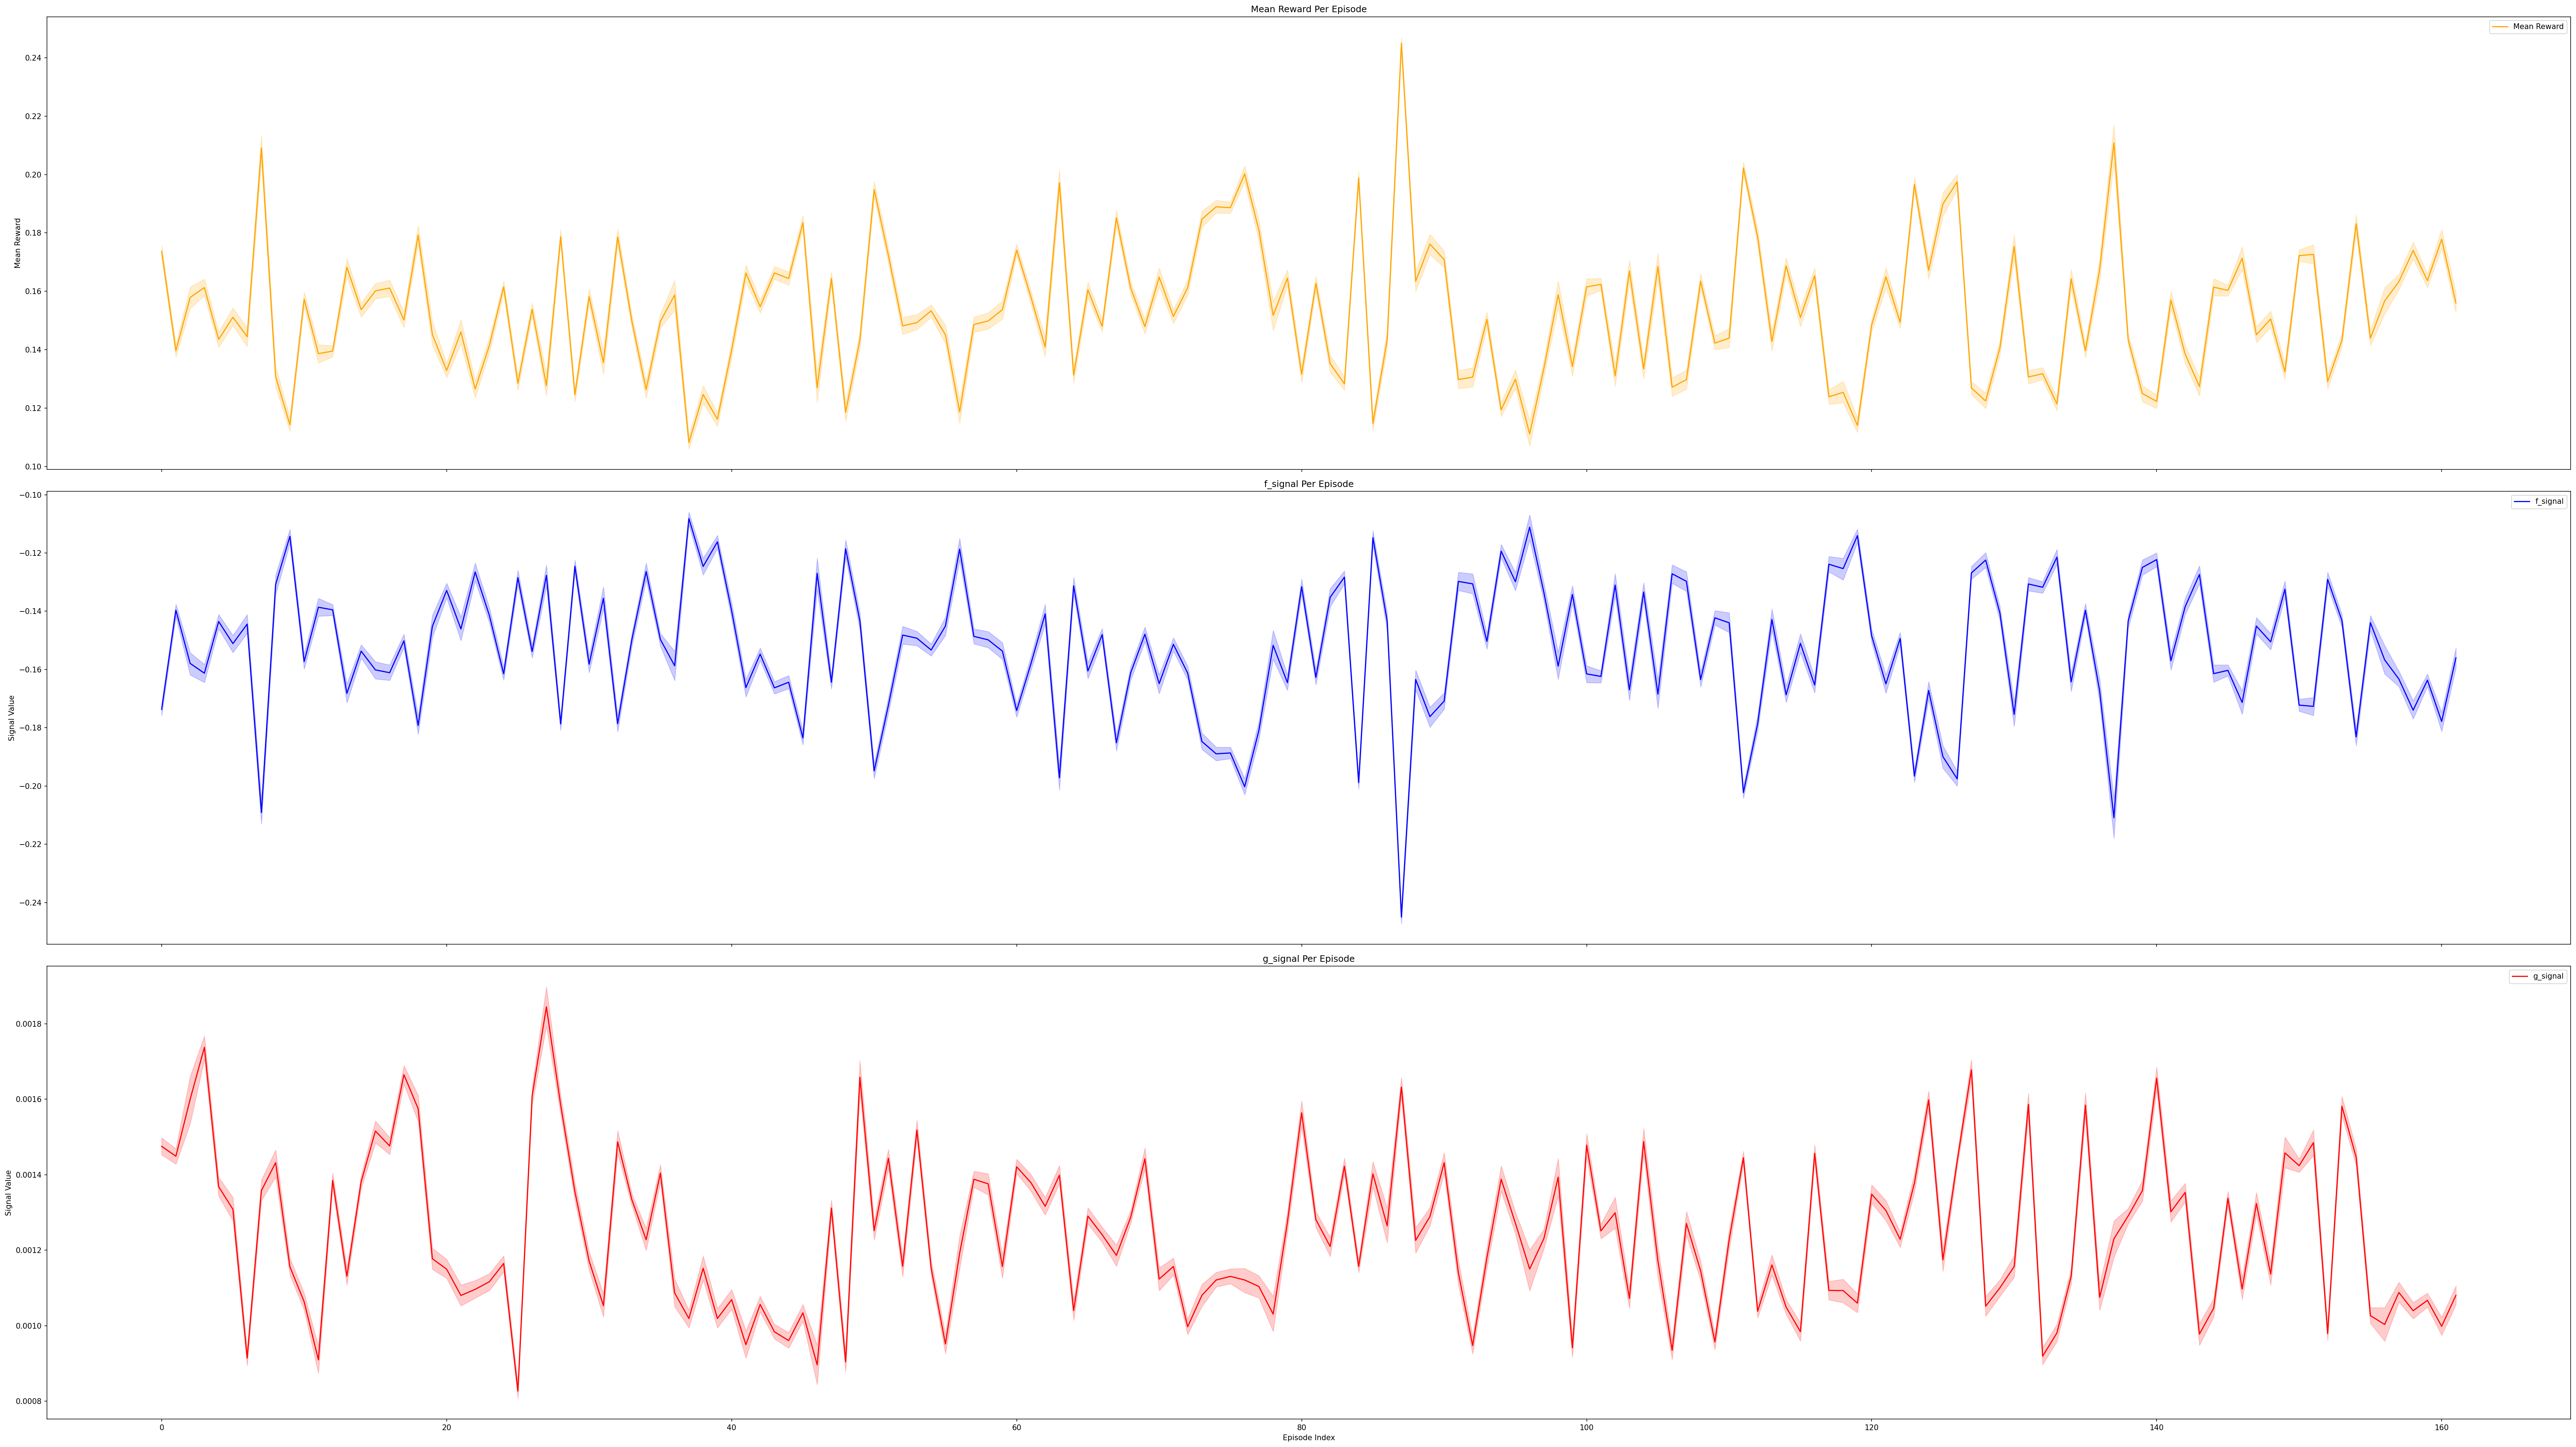

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(48,27), sharex=True, dpi=150)

# Plot the mean and std of per-step reward from episode_info_df
sns.lineplot(data=episode_info_df, x="episode_index", y="reward", ax=ax1, label="Mean Reward", color="orange")
ax1.set_title("Mean Reward Per Episode")
ax1.set_ylabel("Mean Reward")
ax1.legend()

# plot the mean & sd of f_signal and g_signal
sns.lineplot(data=episode_info_df, x="episode_index", y="f_signal", ax=ax2, label="f_signal", color="blue")
ax2.set_title("f_signal Per Episode")
ax2.set_ylabel("Signal Value")
ax2.legend()

sns.lineplot(data=episode_info_df, x="episode_index", y="g_signal", ax=ax3, label="g_signal", color="red")
ax3.set_title("g_signal Per Episode")
ax3.set_ylabel("Signal Value")
ax3.legend()


plt.xlabel("Episode Index")
plt.tight_layout()

fig.savefig(expt_folder / "graphs" / "episode_info_plot.png", dpi=300, bbox_inches='tight')
fig.show()

We can also plot how the training loss of the H-network varies across episodes

In [15]:
h_network_loss_df

mean_loss  std_loss  num_batches
0     0.643874  0.111053            2
1     0.565453  0.025961            2
2     0.500125  0.036831            2
3     0.462213  0.022587            2
4     0.461223  0.020260            2
..         ...       ...          ...
196   0.006480  0.000425            2
197   0.007158  0.001254            2
198   0.006071  0.000029            2
199   0.009792  0.002063            2
200   0.024819  0.005585            2

[201 rows x 3 columns]

In [16]:
# add a column for the episode number, which is equal to (index + 1) * 5
# as the H-network is updated every 5 steps
h_network_loss_df['episode_index'] = (h_network_loss_df.index + 1) * 5

/tmp/ipykernel_2067408/1538420734.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


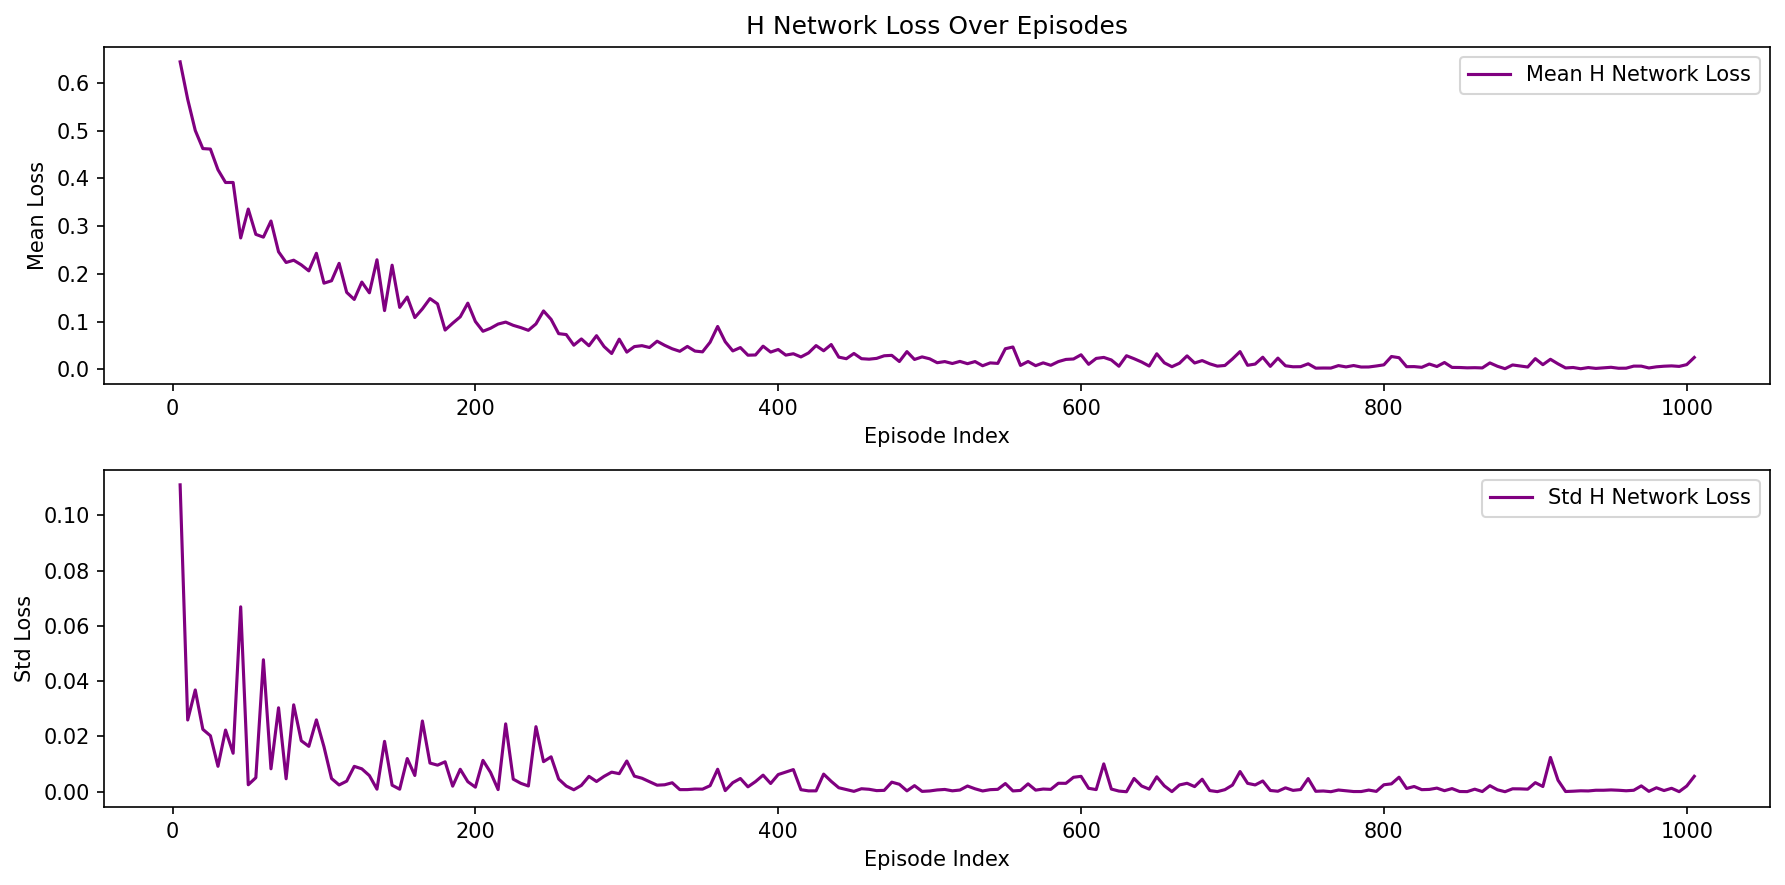

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the h_network_loss_df, both mean_loss and std_loss
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), dpi=150)
sns.lineplot(data=h_network_loss_df, x="episode_index", y="mean_loss", ax=ax1, label="Mean H Network Loss", color="purple")
sns.lineplot(data=h_network_loss_df, x="episode_index", y="std_loss", ax=ax2, label="Std H Network Loss", color="purple")
ax1.set_title("H Network Loss Over Episodes")
ax1.set_ylabel("Mean Loss")
ax1.set_xlabel("Episode Index")
ax2.set_ylabel("Std Loss")
ax2.set_xlabel("Episode Index")
ax1.legend()
ax2.legend()
plt.tight_layout()

fig.savefig(expt_folder / "graphs" / "h_network_loss_plot.png", dpi=300, bbox_inches='tight')
fig.show()


For each of the episode_info in episode_info_list, we first plot how the user load and grid load changes across time

It will be a graph with two subplot, with the first one ploting both user load and (masked) grid load, and the second one plotting the battery state-of-charge

For the second sub-plot, we have to calculate the colour of each point/line. The line will be green if the soc increases, and line wiil be red if the soc decreases, and blue if there's no change

[2025-07-21 12:51:37:419] Plotting episode 150 @ ittr 500 details...


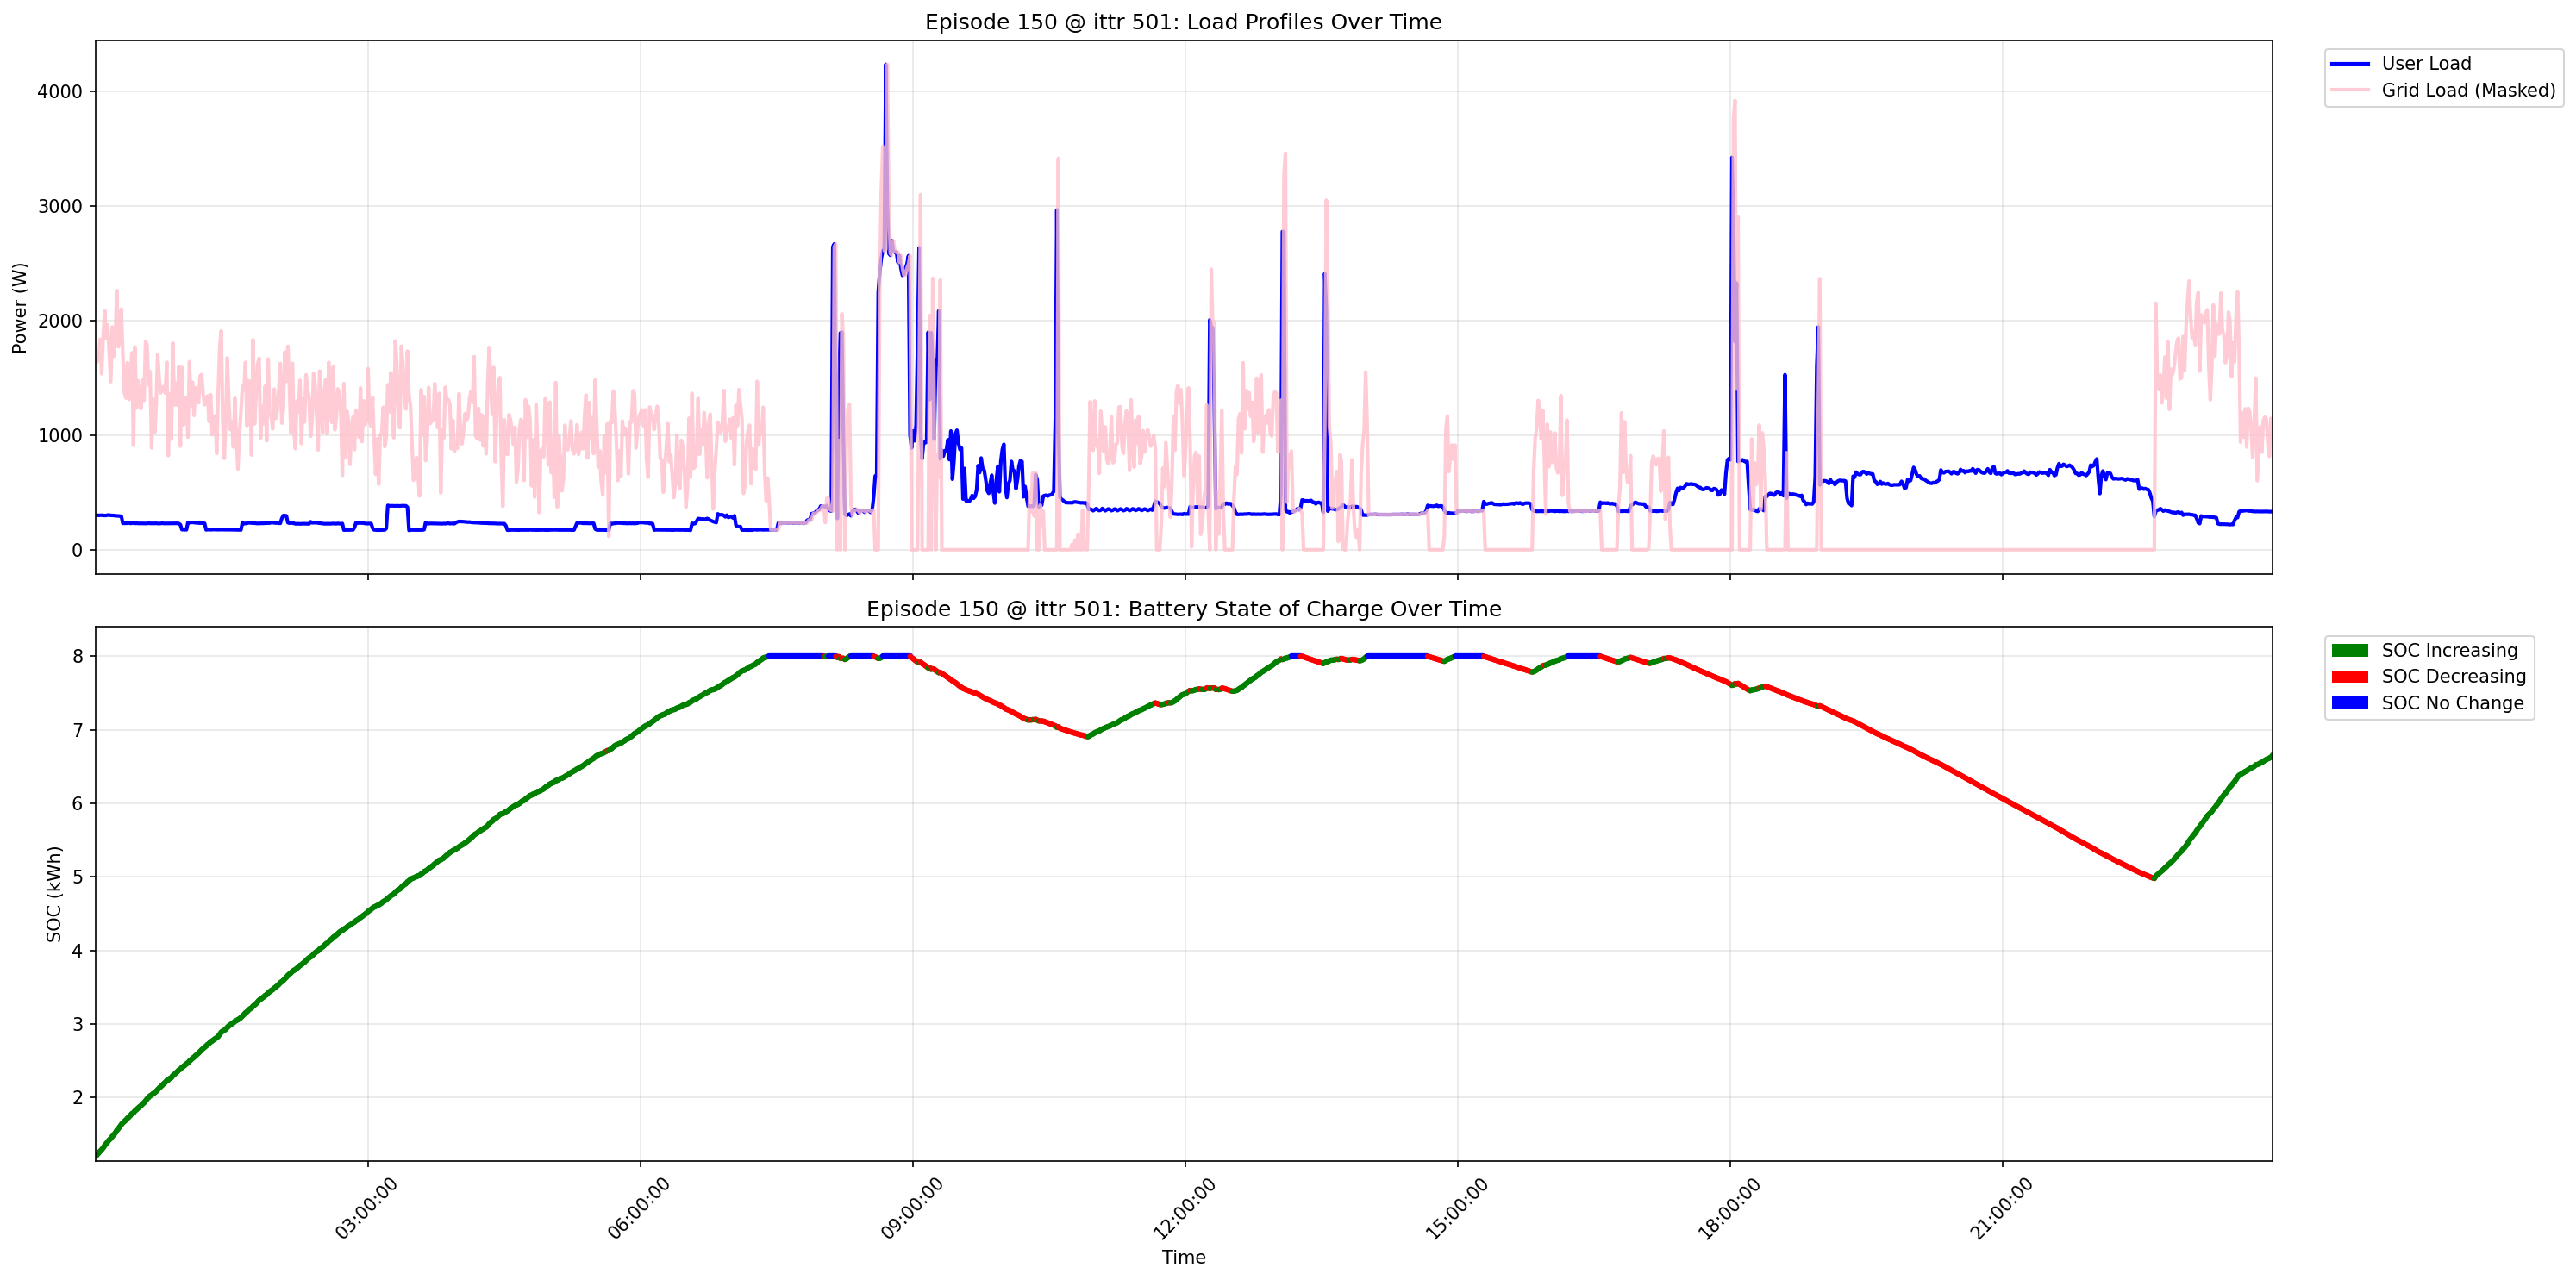

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

# Plot individual episodes with user load, grid load, and battery SOC
def plot_episode_details(episode_df, episode_idx, save_path=None, use_datetime=False, show=True):
    """
    Plot episode details with user load, grid load, and battery SOC (updated with datetime option)
    
    Args:
        episode_df: DataFrame containing episode information
        episode_idx: Episode index for title
        save_path: Optional path to save the figure
        use_datetime: If True, use datetime as x-axis; if False, use step numbers
        show: If True, display the plot; if False, suppress display
    """
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True, dpi=150)
    
    # Determine x-axis values
    if use_datetime and 'datetime' in episode_df.columns:
        x_values = episode_df['datetime']
        x_label = 'Time'
    else:
        x_values = range(len(episode_df))
        x_label = 'Time Steps'

    episode_ittr = episode_df['episode'].iloc[0]  # Get the episode iteration number for title
    
    # First subplot: User load and Grid load
    ax1.plot(x_values, episode_df['user_load (W)'], label='User Load', color='blue', linewidth=2)
    ax1.plot(x_values, episode_df['grid_load (W)'], label='Grid Load (Masked)', color='pink', linewidth=2, alpha=0.8)

    ax1.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: Load Profiles Over Time')
    ax1.set_ylabel('Power (W)')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Second subplot: Battery SOC with color coding using LineCollection
    soc_values = episode_df['battery_soc (kWh)'].values
    
    # Calculate SOC changes
    soc_changes = np.diff(soc_values)
    
    # Create numerical color array based on SOC changes for smooth coloring
    # -1: red (decreasing), 0: blue (no change), 1: green (increasing)
    color_values = []
    for change in soc_changes:
        if change > 1e-6:  # Small threshold to handle floating point precision
            color_values.append(1)    # SOC increases (green)
        elif change < -1e-6:
            color_values.append(-1)   # SOC decreases (red)
        else:
            color_values.append(0)    # No change (blue)
    
    # Create line segments for LineCollection
    if use_datetime and 'datetime' in episode_df.columns:
        # Convert datetime to matplotlib date numbers for LineCollection
        from matplotlib.dates import date2num
        x_numeric = date2num(episode_df['datetime'])
    else:
        x_numeric = np.array(range(len(episode_df)))
    
    points = np.array([x_numeric, soc_values]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create LineCollection with custom colormap
    lc = LineCollection(segments, linewidth=3, capstyle='round')
    lc.set_array(np.array(color_values))
    
    # Create custom colormap: red (-1) -> blue (0) -> green (1)
    colors_map = ['red', 'blue', 'green']
    cmap = ListedColormap(colors_map, name='soc_change', N=3)
    
    lc.set_cmap(cmap)
    lc.set_clim(-1, 1)
    
    # Add the line collection to the plot
    line = ax2.add_collection(lc)

    ax2.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: Battery State of Charge Over Time')
    ax2.set_xlabel(x_label)
    ax2.set_ylabel('SOC (kWh)')
    ax2.grid(True, alpha=0.3)
    
    # Set axis limits for better visualization
    if use_datetime and 'datetime' in episode_df.columns:
        ax2.set_xlim(episode_df['datetime'].iloc[0], episode_df['datetime'].iloc[-1])
    else:
        ax2.set_xlim(0, len(episode_df)-1)
    ax2.set_ylim(soc_values.min() * 0.95, soc_values.max() * 1.05)
    
    # Add legend for SOC colors
    legend_elements = [Patch(facecolor='green', label='SOC Increasing'),
                      Patch(facecolor='red', label='SOC Decreasing'),
                      Patch(facecolor='blue', label='SOC No Change')]
    ax2.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left')
    
    # Format datetime axis if using datetime
    if use_datetime and 'datetime' in episode_df.columns:
        from matplotlib.dates import DateFormatter
        # Format the datetime axis
        formatter = DateFormatter('%H:%M:%S')
        for ax in [ax1, ax2]:
            ax.xaxis.set_major_formatter(formatter)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    return fig

# Plot details for selected episodes (first 5 episodes as example)
# You can modify the range to plot more or specific episodes
# episodes_to_plot = range(min(1, len(episode_info_dfs)))  # Plot first 5 episodes or all if less than 5
episodes_to_plot = [500]  # Plot first 5 episodes or all if less than 5

for i in episodes_to_plot:
    episode_df = episode_info_dfs[i]
    episode_idx = episode_df['episode_index'].iloc[0]  # Get the actual episode index
    
    print_log(f"Plotting episode {episode_idx} @ ittr {i} details...")
    
    # Create save path for individual episode plots
    save_path = expt_folder / "graphs" / "per_episode" /f"episode_{episode_idx}_details.png"

    fig = plot_episode_details(episode_df, episode_idx, save_path=None, use_datetime=True, show=True)

    # Close the figure to free memory
    # plt.close(fig)

In [19]:
episode_df

episode_index  current_step            datetime  battery_soc (%)  \
0               150             0 2013-12-03 00:00:02         0.150000   
1               150             1 2013-12-03 00:01:02         0.152798   
2               150             2 2013-12-03 00:02:02         0.155674   
3               150             3 2013-12-03 00:03:02         0.158875   
4               150             4 2013-12-03 00:04:02         0.161449   
...             ...           ...                 ...              ...   
1435            150          1435 2013-12-03 23:55:02         0.825899   
1436            150          1436 2013-12-03 23:56:02         0.826901   
1437            150          1437 2013-12-03 23:57:02         0.828595   
1438            150          1438 2013-12-03 23:58:02         0.829887   
1439            150          1438 2013-12-03 23:58:02         0.831975   

      battery_soc (kWh)  user_load (W)  grid_load (W)  action (kW)  \
0              1.200000            NaN            NaN          NaN   
1              1.222386     300.784320    1643.165636     1.343166   
2              1.245395     300.177455    1681.343526     1.380559   
3              1.271004     300.688967    1836.668968     1.536492   
4              1.291592     301.756905    1535.978779     1.235290   
...                 ...            ...            ...          ...   
1435           6.607189     333.424103     916.631190     0.581936   
1436           6.615210     333.093581     814.657461     0.481233   
1437           6.628759     332.310867    1146.076081     0.812982   
1438           6.639096     334.235391     952.496898     0.620186   
1439           6.655802     334.235391     952.496898     1.002385   

      battery_action (kW)    reward  f_signal  g_signal  \
0                     NaN       NaN       NaN       NaN   
1                1.343166  0.366952 -0.366952  0.002261   
2                1.380559  0.339532 -0.339532  0.002324   
3                1.536492  0.367582 -0.367582  0.002586   
4                1.235290  0.332257 -0.332257  0.002079   
...                   ...       ...       ...       ...   
1435             0.581936  0.106501 -0.106501  0.000980   
1436             0.481233  0.101903 -0.101903  0.000810   
1437             0.812982  0.186186 -0.186186  0.001369   
1438             0.620186  0.107999 -0.107999  0.001044   
1439             1.002385  0.207220 -0.207220  0.001687   

      f_signal-predicted_mean  f_signal-predicted_log_var  f_signal-target  \
0                         NaN                         NaN              NaN   
1                    0.996168                         0.0        -0.368107   
2                    1.336653                         0.0        -0.369583   
3                    1.074386                         0.0        -0.368339   
4                    0.742285                         0.0        -0.365742   
...                       ...                         ...              ...   
1435                 0.201345                         0.0        -0.288737   
1436                 0.188445                         0.0        -0.289541   
1437                 0.395091                         0.0        -0.291444   
1438                 0.207227                         0.0        -0.286764   
1439                 0.457134                         0.0        -0.280420   

     TimeLimit.truncated  episode  
0                    NaN      501  
1                  False      501  
2                  False      501  
3                  False      501  
4                  False      501  
...                  ...      ...  
1435               False      501  
1436               False      501  
1437               False      501  
1438               False      501  
1439                 NaN      501  

[1440 rows x 17 columns]

In [12]:
# Plot individual episodes with three separate subplots
def plot_episode_details_three_subplots(episode_df, episode_idx, save_path=None, use_datetime=False, show=True):
    """
    Plot episode details with three separate subplots: user load, grid load, and battery SOC
    
    Args:
        episode_df: DataFrame containing episode information
        episode_idx: Episode index for title
        save_path: Optional path to save the figure
        use_datetime: If True, use datetime as x-axis; if False, use step numbers
        show: If True, display the plot; if False, suppress display
    """
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 15), sharex=True, dpi=150)
    
    # Determine x-axis values
    if use_datetime and 'datetime' in episode_df.columns:
        x_values = episode_df['datetime']
        x_label = 'Time'
    else:
        x_values = range(len(episode_df))
        x_label = 'Time Steps'

    episode_ittr = episode_df['episode'].iloc[0]  # Get the episode iteration number for title
    
    # First subplot: User load only
    ax1.plot(x_values, episode_df['user_load (W)'], label='User Load', color='blue', linewidth=2)
    ax1.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: User Load Over Time')
    ax1.set_ylabel('Power (W)')
    ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax1.grid(True, alpha=0.3)
    
    # Second subplot: Grid load only  
    ax2.plot(x_values, episode_df['grid_load (W)'], label='Grid Load (Masked)', color='orange', linewidth=2, alpha=0.8)
    ax2.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: Grid Load (Masked) Over Time')
    ax2.set_ylabel('Power (W)')
    ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
    ax2.grid(True, alpha=0.3)
    
    # Third subplot: Battery SOC with color coding using LineCollection
    soc_values = episode_df['battery_soc (kWh)'].values
    
    # Calculate SOC changes
    soc_changes = np.diff(soc_values)
    
    # Create numerical color array based on SOC changes for smooth coloring
    # -1: red (decreasing), 0: blue (no change), 1: green (increasing)
    color_values = []
    for change in soc_changes:
        if change > 1e-6:  # Small threshold to handle floating point precision
            color_values.append(1)    # SOC increases (green)
        elif change < -1e-6:
            color_values.append(-1)   # SOC decreases (red)
        else:
            color_values.append(0)    # No change (blue)
    
    # Create line segments for LineCollection
    if use_datetime and 'datetime' in episode_df.columns:
        # Convert datetime to matplotlib date numbers for LineCollection
        from matplotlib.dates import date2num
        x_numeric = date2num(episode_df['datetime'])
    else:
        x_numeric = np.array(range(len(episode_df)))
    
    points = np.array([x_numeric, soc_values]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # Create LineCollection with custom colormap
    lc = LineCollection(segments, linewidth=3, capstyle='round')
    lc.set_array(np.array(color_values))
    
    # Create custom colormap: red (-1) -> blue (0) -> green (1)
    colors_map = ['red', 'blue', 'green']
    cmap = ListedColormap(colors_map, name='soc_change', N=3)
    
    lc.set_cmap(cmap)
    lc.set_clim(-1, 1)
    
    # Add the line collection to the plot
    line = ax3.add_collection(lc)

    ax3.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}: Battery State of Charge Over Time')
    ax3.set_xlabel(x_label)
    ax3.set_ylabel('SOC (kWh)')
    ax3.grid(True, alpha=0.3)
    
    # Set axis limits for better visualization
    if use_datetime and 'datetime' in episode_df.columns:
        ax3.set_xlim(episode_df['datetime'].iloc[0], episode_df['datetime'].iloc[-1])
    else:
        ax3.set_xlim(0, len(episode_df)-1)
    ax3.set_ylim(soc_values.min() * 0.95, soc_values.max() * 1.05)
    
    # Add legend for SOC colors
    legend_elements = [Patch(facecolor='green', label='SOC Increasing'),
                      Patch(facecolor='red', label='SOC Decreasing'),
                      Patch(facecolor='blue', label='SOC No Change')]
    ax3.legend(handles=legend_elements, bbox_to_anchor=(1.02, 1), loc='upper left')
    
    # Format datetime axis if using datetime
    if use_datetime and 'datetime' in episode_df.columns:
        from matplotlib.dates import DateFormatter
        # Format the datetime axis
        formatter = DateFormatter('%H:%M:%S')
        for ax in [ax1, ax2, ax3]:
            ax.xaxis.set_major_formatter(formatter)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    return fig

In [20]:
# Example 2: Three subplots with datetime
# print_log("Creating three-subplot version with datetime...")
# save_path_3sub_datetime = expt_folder / "graphs" / "per_episode" / f"episode_{episode_idx}_three_subplots_datetime.png"
# fig2 = plot_episode_details_three_subplots(episode_df, episode_idx, save_path=save_path_3sub_datetime, use_datetime=True)
# plt.close(fig2)

In [ ]:
# for each episode, plot the details with three subplots with datetime enabled
# then save the figure in the per_episode folder
for i in range(0, len(episode_info_dfs)):
    episode_df = episode_info_dfs[i]
    episode_idx = episode_df['episode_index'].iloc[0]  # Get the actual episode index
    
    # Create save path for individual episode plots
    save_path = expt_folder / "graphs" / "per_episode" / f"episode_{i+1:0>4d}_three_subplots.png"

    if not save_path.parent.exists():
        save_path.parent.mkdir(parents=True)

    fig = plot_episode_details_three_subplots(episode_df, episode_idx, save_path=save_path, use_datetime=True, show=False)

    # Close the figure to free memory
    plt.close('all')

Another way to perform that is we create a dictionary with key = episode_index

Then we put the episode_idx to each value of the dictionary

In [16]:
grouped_episode_idx = {}

for i, episode_df in enumerate(episode_info_dfs):
    episode_idx = episode_df['episode_index'].iloc[0]  # Get the actual episode index
    if episode_idx not in grouped_episode_idx:
        grouped_episode_idx[episode_idx] = []
    grouped_episode_idx[episode_idx].append(i)  # Store the index of the episode_df w.r.t. episode_info_dfs

grouped_episode_idx

{96: [0, 348],
 8: [1, 272, 684, 695],
 147: [2, 148, 464, 790, 930, 982],
 35: [3, 63, 265, 361, 390, 466, 488, 693, 923],
 41: [4, 54, 101, 258, 662],
 29: [5, 47, 195, 257, 284, 287, 569, 754, 864],
 54: [6, 118, 177, 268, 421, 494, 657, 691, 704, 839, 858],
 28: [7, 87, 164, 234, 344, 409, 674, 978, 1006],
 56: [8, 301, 721],
 131: [9, 117, 138, 179, 336, 856, 936, 980],
 73: [10, 72, 232, 398, 525, 933],
 149: [11, 86, 315, 381, 920],
 72: [12, 244, 256, 388, 424, 697, 914],
 44: [13, 255, 520, 551, 599, 616, 895, 992],
 127: [14, 289, 383, 536, 675, 777, 813, 852],
 132: [15, 182, 218, 404, 632, 683, 984],
 139: [16, 203, 288, 385, 469, 786, 966],
 144: [17, 280, 515, 535, 542],
 4: [18, 197, 202, 328, 441, 483, 871],
 83: [19, 37, 58, 310, 420, 774, 821, 846, 925, 958],
 43: [20, 115, 397, 406, 411, 522, 571, 747, 768, 916],
 39: [21, 22, 40, 223, 365, 713, 1007],
 133: [23, 176, 380, 438, 505, 546, 874],
 128: [24, 38, 366, 660, 832, 890],
 34: [25, 36, 389, 453, 514],
 66: [26

---

[2025-07-21 12:56:02:825] Creating episodes grid summary plot...
[2025-07-21 12:56:02:825] Plotting episodes: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]


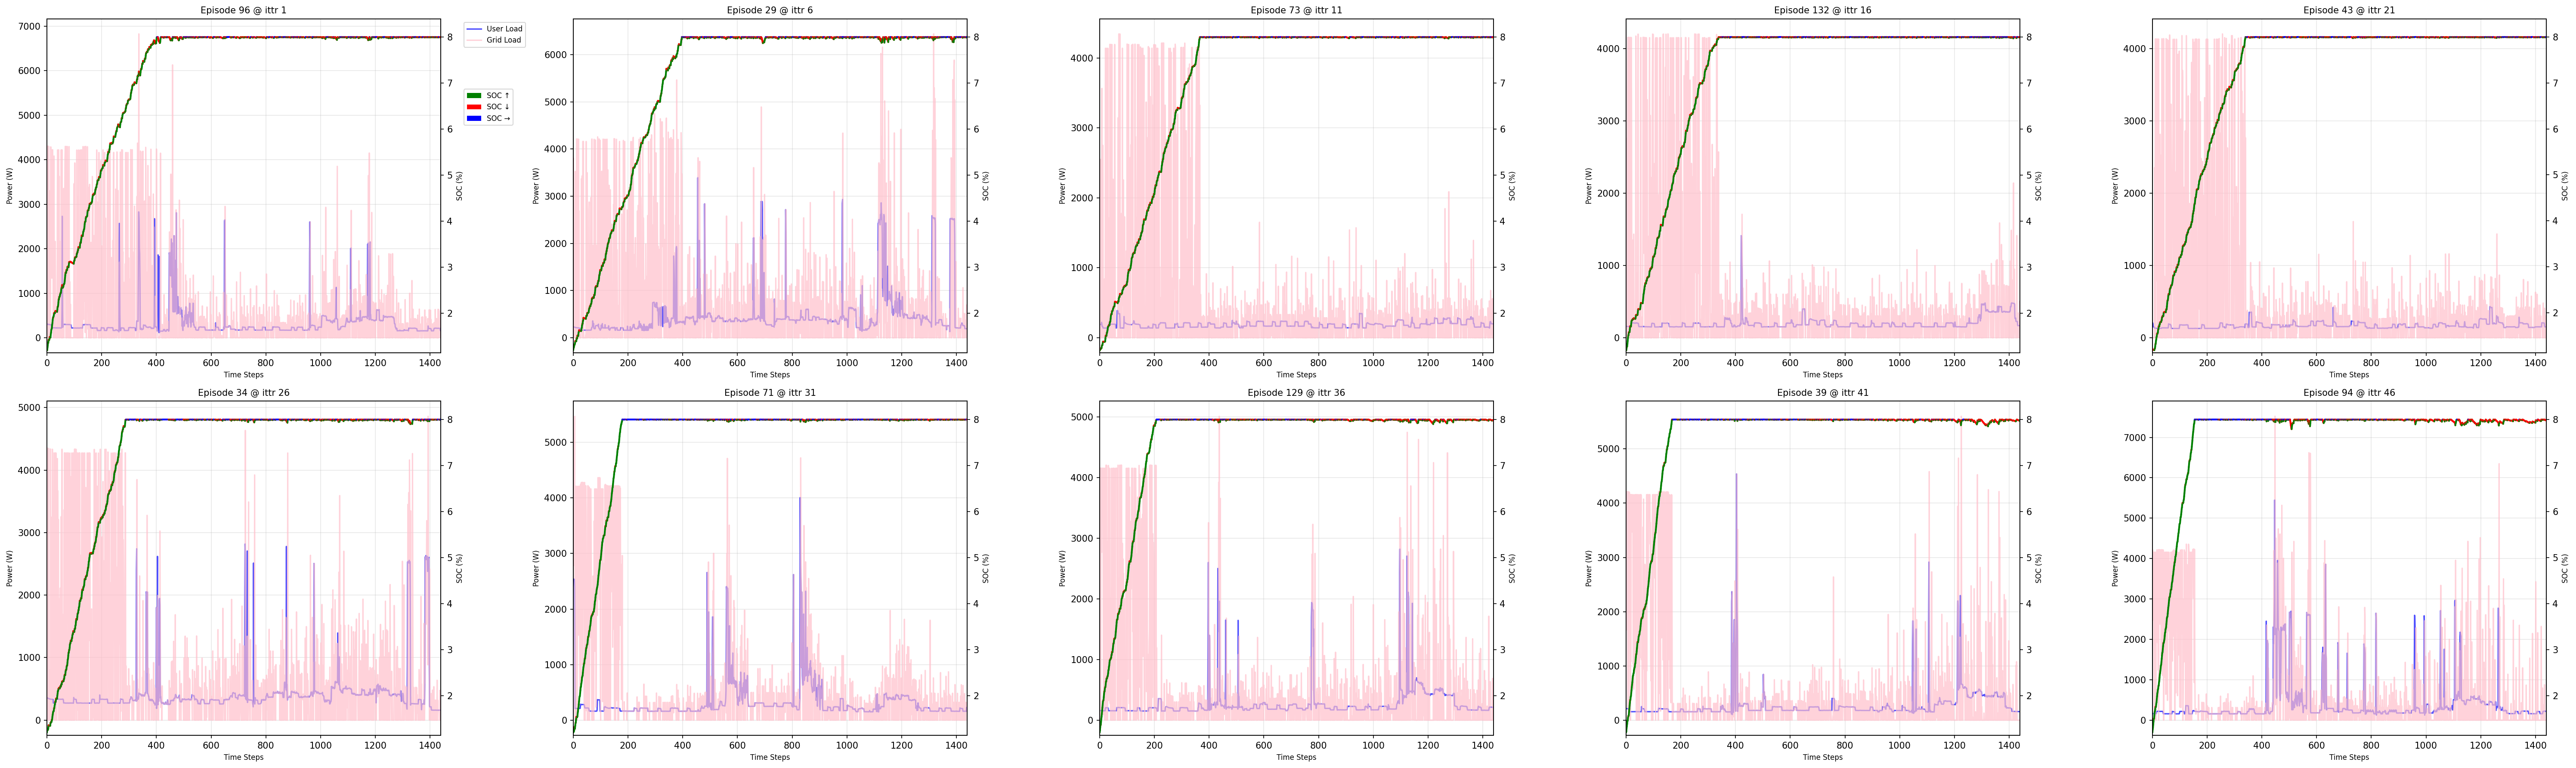

In [17]:
# Create a summary grid plot showing multiple episodes
def plot_episodes_grid(episode_dfs_list, episode_indices=None, save_path=None, show=True):
    """
    Create a grid plot showing multiple episodes in subplots
    
    Args:
        episode_dfs_list: List of episode DataFrames
        episode_indices: List of episode indices to plot (e.g., [0, 5, 10, 15]). 
                        If None, plots first 9 episodes.
        save_path: Optional path to save the figure
    """
    # Determine which episodes to plot
    if episode_indices is None:
        n_episodes = min(len(episode_dfs_list), 9)
        episodes_to_plot = list(range(n_episodes))
    else:
        episodes_to_plot = [idx for idx in episode_indices if idx < len(episode_dfs_list)]
        n_episodes = len(episodes_to_plot)
    
    if n_episodes == 0:
        print("No valid episodes to plot.")
        return None
    
    # Compute optimal grid layout
    def compute_optimal_layout(n):
        """Compute optimal number of rows and columns for n subplots"""
        if n <= 0:
            return 1, 1
        elif n == 1:
            return 1, 1
        elif n == 2:
            return 1, 2
        elif n == 3:
            return 1, 3
        elif n == 4:
            return 2, 2
        elif n <= 6:
            return 2, 3
        elif n <= 8:
            return 2, 4
        elif n <= 10:
            return 2, 5
        else:
            # For larger numbers, try to keep aspect ratio reasonable
            cols = int(np.ceil(np.sqrt(n)))
            rows = int(np.ceil(n / cols))
            return rows, cols
    
    n_rows, n_cols = compute_optimal_layout(n_episodes)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6*n_rows), dpi=150)
    
    # Handle single subplot case
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    for i in range(n_episodes):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 or n_cols > 1 else axes[0, 0]
        
        # Get the episode index and corresponding dataframe
        episode_idx_in_list = episodes_to_plot[i]
        episode_df = episode_dfs_list[episode_idx_in_list]
        episode_idx = episode_df['episode_index'].iloc[0]
        episode_ittr = episode_df['episode'].iloc[0]
        time_steps = range(len(episode_df))
        
        # Plot user load and grid load
        ax.plot(time_steps, episode_df['user_load (W)'], label='User Load', color='blue', alpha=0.7)
        ax.plot(time_steps, episode_df['grid_load (W)'], label='Grid Load', color='pink', alpha=0.7)
        
        # Plot SOC on secondary y-axis with LineCollection
        ax2 = ax.twinx()
        soc_values = episode_df['battery_soc (kWh)'].values
        soc_changes = np.diff(soc_values)
        
        # Create numerical color array based on SOC changes
        color_values = []
        for change in soc_changes:
            if change > 1e-6:
                color_values.append(1)    # SOC increases (green)
            elif change < -1e-6:
                color_values.append(-1)   # SOC decreases (red)  
            else:
                color_values.append(0)    # No change (blue)
        
        # Create line segments for LineCollection
        from matplotlib.collections import LineCollection
        points = np.array([time_steps, soc_values]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create LineCollection with custom colormap
        lc = LineCollection(segments, linewidth=2, capstyle='round')
        lc.set_array(np.array(color_values))
        
        # Create custom colormap: red (-1) -> blue (0) -> green (1)
        from matplotlib.colors import ListedColormap
        colors_map = ['red', 'blue', 'green']
        cmap = ListedColormap(colors_map, name='soc_change', N=3)
        
        lc.set_cmap(cmap)
        lc.set_clim(-1, 1)
        
        # Add the line collection to the plot
        line = ax2.add_collection(lc)

        ax.set_title(f'Episode {episode_idx} @ ittr {episode_ittr}', fontsize=10)
        ax.set_xlabel('Time Steps', fontsize=8)
        ax.set_ylabel('Power (W)', fontsize=8)
        ax2.set_ylabel('SOC (%)', fontsize=8)
        
        # Set axis limits for better visualization
        ax2.set_xlim(0, len(time_steps)-1)
        ax2.set_ylim(soc_values.min() * 0.95, soc_values.max() * 1.05)
        
        if i == 0:  # Add legend only to first subplot
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
            # Add SOC legend
            legend_elements = [Patch(facecolor='green', label='SOC ↑'),
                             Patch(facecolor='red', label='SOC ↓'),
                             Patch(facecolor='blue', label='SOC →')]
            ax2.legend(handles=legend_elements, bbox_to_anchor=(1.05, 0.8), loc='upper left', fontsize=8)
        
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(n_episodes, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows > 1 or n_cols > 1:
            ax = axes[row, col]
        else:
            continue  # No empty plots for single subplot
        ax.set_visible(False)
    
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    if show:
        plt.show()
    return fig

# Create grid summary plot
print_log("Creating episodes grid summary plot...")

# Example 1: Plot first 9 episodes (default behavior)
# fig_grid = plot_episodes_grid(episode_info_dfs, save_path=grid_save_path)

# Example 2: Plot specific episodes with step=5 (episodes 100, 105, 110, 115, ...)
episode_indices = [i for i in range(0, min(50, len(episode_info_dfs)), 5)]  # [0, 5, 10, 15, ..., 45]
print_log(f"Plotting episodes: {episode_indices}")

grid_save_path = expt_folder / "graphs" / f"episodes_grid_summary_[{episode_indices[0]}_{episode_indices[-1]}].png"
fig_grid = plot_episodes_grid(episode_info_dfs, episode_indices=episode_indices, save_path=None)
plt.close('all')

In [18]:
# Create multiple grid summary plots for different episode ranges
# Each plot will show 10 episodes with step=5

total_episodes = len(episode_info_dfs)
episodes_per_plot = 10  # Number of episodes per grid plot
step_size = 5           # Step between episodes

# Calculate how many plots we need based on episodes_per_plot * step_size chunks
chunk_size = episodes_per_plot * step_size  # 50 episodes per chunk

print_log(f"Total episodes available: {total_episodes}")
print_log(f"Creating grid plots for every {episodes_per_plot} episodes (step={step_size})")

for start_idx in range(0, total_episodes, chunk_size):
    # Create episode indices for this chunk: [start_idx, start_idx+5, start_idx+10, ..., start_idx+45]
    episode_indices = [i for i in range(start_idx, min(start_idx + chunk_size, total_episodes), step_size)]
    
    # Only create plot if we have at least a few episodes
    if len(episode_indices) >= 2:
        print_log(f"Creating grid plot for episodes: {episode_indices}")
        
        # Create filename with episode range
        grid_save_path = expt_folder / "graphs" / f"episodes_grid_summary_[{episode_indices[0]:04d}_{episode_indices[-1]:04d}].png"

        # Create and save the plot
        fig_grid = plot_episodes_grid(episode_info_dfs, episode_indices=episode_indices, save_path=grid_save_path, show=False)

        # Close figure to free memory
        if fig_grid:
            plt.close('all')
    else:
        print_log(f"Skipping range starting at {start_idx} - not enough episodes remaining")

print_log("Completed creating all grid summary plots.")

[2025-07-21 12:56:13:952] Total episodes available: 1009
[2025-07-21 12:56:13:952] Creating grid plots for every 10 episodes (step=5)
[2025-07-21 12:56:13:952] Creating grid plot for episodes: [0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
[2025-07-21 12:56:16:225] Creating grid plot for episodes: [50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
[2025-07-21 12:56:16:225] Creating grid plot for episodes: [50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
[2025-07-21 12:56:19:058] Creating grid plot for episodes: [100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
[2025-07-21 12:56:19:058] Creating grid plot for episodes: [100, 105, 110, 115, 120, 125, 130, 135, 140, 145]
[2025-07-21 12:56:21:228] Creating grid plot for episodes: [150, 155, 160, 165, 170, 175, 180, 185, 190, 195]
[2025-07-21 12:56:21:228] Creating grid plot for episodes: [150, 155, 160, 165, 170, 175, 180, 185, 190, 195]
[2025-07-21 12:56:23:836] Creating grid plot for episodes: [200, 205, 210, 215, 220, 225, 230, 235, 240, 245]
[2025-07-21 12:56:

In [19]:
# another example: plot the same episode with different episode indices
# This is useful to compare the same episode with different indices

for k in grouped_episode_idx.keys():
    if len(grouped_episode_idx[k]) >= 1:
        print_log(f"Plotting episode {k:04d} with indices: {grouped_episode_idx[k]}")

        # Create a save path for the grid plot
        grid_save_path = expt_folder / "graphs" / "grouped_by_episode_idx" / f"episode_idx_{k:04d}_grid_summary.png"

        if not grid_save_path.parent.exists():
            grid_save_path.parent.mkdir(parents=True)

        fig_grid = plot_episodes_grid(episode_info_dfs, episode_indices=grouped_episode_idx[k], save_path=grid_save_path, show=False)
        plt.close('all')

[2025-07-21 12:58:23:205] Plotting episode 0096 with indices: [0, 348]
[2025-07-21 12:58:23:674] Plotting episode 0008 with indices: [1, 272, 684, 695]
[2025-07-21 12:58:23:674] Plotting episode 0008 with indices: [1, 272, 684, 695]
[2025-07-21 12:58:24:546] Plotting episode 0147 with indices: [2, 148, 464, 790, 930, 982]
[2025-07-21 12:58:24:546] Plotting episode 0147 with indices: [2, 148, 464, 790, 930, 982]
[2025-07-21 12:58:26:664] Plotting episode 0035 with indices: [3, 63, 265, 361, 390, 466, 488, 693, 923]
[2025-07-21 12:58:26:664] Plotting episode 0035 with indices: [3, 63, 265, 361, 390, 466, 488, 693, 923]
[2025-07-21 12:58:28:753] Plotting episode 0041 with indices: [4, 54, 101, 258, 662]
[2025-07-21 12:58:28:753] Plotting episode 0041 with indices: [4, 54, 101, 258, 662]
[2025-07-21 12:58:29:918] Plotting episode 0029 with indices: [5, 47, 195, 257, 284, 287, 569, 754, 864]
[2025-07-21 12:58:29:918] Plotting episode 0029 with indices: [5, 47, 195, 257, 284, 287, 569, 754, 